# Introduction to Machine Learning

We are going to use [JAX](https://github.com/google/jax) for this part of the demo - because it lets you get into the internals of how ML works in a way other libraries do.

In [ ]:
!pip install jax[cpu]

## Some Straight Line Data

Who hasn't been _forced_ to fit a straight line?

Lets create some data that approximates a straight line, with some "errors". We'll fit this!

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:
# random number tracking in JAX
rng = jax.random.PRNGKey(0)
rng, new_key = jax.random.split(rng)

# Straight line with jitter
x = jax.random.normal(rng, (100,))
jitter = jax.random.normal(new_key, (100,))
y = 3*x + 2 + 0.5*jitter

<br>

In [ ]:
[f"({f_x:0.2f}, {f_y:0.2f})" for f_x, f_y in list(zip(x,y))[0:5]]

We have 100 points like this - best to look at them graphically

## Plotting the Jitter-y straight line

Next, lets plot this to make sure we got what we wanted: A line that is $y = f(x) = mx + b + jitter$, where $m=3$ and $b=2$.

Make a plot:

* The `x` vs `y` scatter
* A solid line that is the `3*x+2` "perfect" line.

In [ ]:
from matplotlib import pyplot as plt



plt.xlabel('x')
plt.ylabel('y')
plt.show()

As expected - a messy line!

## Lets fit this to a line

$y = m*x + b$.

We can do this analytically, using least squares!

Our function to fit to the data is

$f(x) = \beta_0 + \beta_1 * x$

We want to find $\beta_0$ and $\beta_1$ such that we are as close to all the points as possible. That the residuals are small:

$r_i = y_i - f(x_i)$

And we minimize the least squares of that:

$S = \sum r_i^2$

<br>
The minima occur when $\frac{\delta S}{\delta \beta_0}$ and $\frac{\delta S}{\delta \beta_1}$ are zero.

We can determine these two derivatives, and then solve for $\beta_0$ and $\beta_1$.

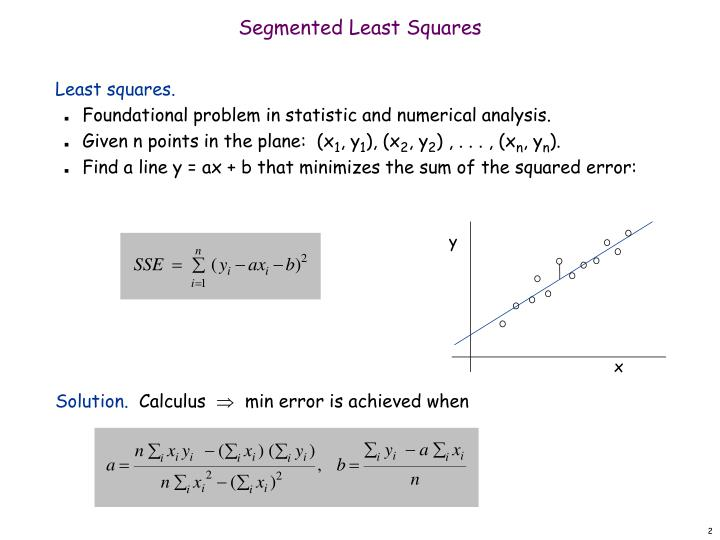

## Least Squares - analytical solution

In [ ]:
n = len(x)
beta_1 = ((n*jnp.sum(x*y) - jnp.sum(x)*jnp.sum(y))
          /
            (n*jnp.sum(x**2) - jnp.sum(x)**2)
)
beta_0 = (jnp.sum(y) - beta_1*jnp.sum(x))/n

#### Values of the fit

In [ ]:
print(f"beta_0: {beta_0:.2f}")
print(f"beta_1: {beta_1:.2f}")

Very close to the expected $b=2.0$ and $m=3.0$! Plot the data, the real line, and the fitted line below.

The real and fitted lines are right on top of each other!

# Neural Networks

Lets start using the formalism from before. We have a set of data $x_i$ and a function $f$ that we'd like the following to hold true for:

$y_i = f(x_i, \beta)$

$f(x_i)$ is the neural network.

* Complex function that can describe $y_i$ given $x_i$
* Has properties that make it possible to solve for $\beta$.

And finally a loss function (like our least-squares):

$L(y_i, f(x_i, \beta))$

## Gradient Decent

We use the gradient decent algorithm to iteratively solve for $\beta$.

1. Evaluate the gradient of $L$ ($\nabla L$) for $x_i$ and $y_i$ for some vector of $\beta$.
1. Adjust $\beta$ by some factor times the gradient.

This will **slowly** move you towards the minimum, where $\frac{\delta L}{\delta \beta} = 0$.

<img src="GD_Diagram.png" width="450">


## The Gradient

Programmatically, calculating the gradient is the hardest thing to do. Which is why we use frameworks like JAX, PyTorch, and TensorFlow. For an example, lets try a super simple function, where $\beta$ is two parameters.

In [ ]:
def x2(beta):
    x, y = beta
    return x**2 + y**2

Evaluate it a few times to convince yourself it does what you expect (for example, pass it proper beta such that the result is 25):

The `grad` function in JAX will take the gradient of the function. A lot of magic happens:

* A *tape* of the function is recorded.
* JAX replays the tape and takes the derivative of every operation
* Applies the product rule. A lot.

In [ ]:
grad_of_x2 = jax.grad(x2)
grad_of_x2

This is a function - the gradient of `x2`.

Note: `jax` will only take the derivative w.r.t. the first argument - which is why we put two values in `beta`. When you have 100's of parameters in `beta` this makes more sense...

Take a few gradients. Note that it returns a tuple! What is going on? And they come back in funny objects. What is going on here? Write your explanation in the cell below this next one.

In [ ]:
print(f'grad_of_x2(1, 1)= {grad_of_x2((1.0,1.0))}')
print(f'grad_of_x2(2, 2)= {grad_of_x2((2.0,3.0))}')
print(f'grad_of_x2(3, 4)= {grad_of_x2((3.0,4.0))}')

Write your explanation in this cell:

xxxxxxx

## Gradient Descent Straight Line Fit

Lets go back and use this technique to apply to the straight line data from earlier.

In [ ]:
def network(beta, x):
    'This is our straight line function y = b0 + b1*x'
    b0, b1 = beta
    return b0 + b1*x

In [ ]:
def loss(params, x, y):
    'This is the leas squares loss function for our straight line model!'
    y_pred = network(params, x)
    return jnp.mean((y_pred - y)**2)

Here we define our *network* and *loss* function

* Note the loss function is just the least squares function from before.
* Note how nicely we can look at this and see what we are doing - nothing like the analytical function above!

## The Gradient

Now that we know what JAX is going to do, this is a bit anti-climatic.

But - this is a much more sophisticated function that the previous simple `x2`!
* So we should still be impressed!

In [ ]:
grad_of_loss = jax.grad(loss)

`grad_of_loss` is a function that calculates the gradient of `loss` for all the data w.r.t. the parameters for the straight line function ($m$ and $b$).

## Update the parameters

Each iteration we calculate the gradient, and adjust the parameters.

In [ ]:
def one_epoch(beta, x, y, i_epoch):
    g = grad_of_loss(beta, x, y)
    beta -= 0.1*g
    print(f'Step {i_epoch}, loss {loss(beta, x, y)} and beta {beta}')
    return beta

Note the `0.1`:

* This is the _learning rate_.
* Adjust it to help converge more or less quickly
* Too large can mean you miss the minimum
* There are sophisticated algorithms that calculate different learning rates on the fly.

## Training

Lets loop 10 times:

In [ ]:
beta = jnp.array([1.0, 1.0])

for i_epoch in range(10):
    beta = one_epoch(beta, x, y, i_epoch)

In [ ]:
print(f"Final parameters: {beta}")

This was after only 10 epochs, but we can see that we are getting close here!

## Training History

Lets do a longer training and track the parameters so we can see how they converge.

In [ ]:
beta = jnp.array([1.0, 1.0])
beta_history = [beta]
for i in range(50):
    beta = one_epoch(beta, x, y, i)
    beta_history.append(beta.copy())

At the end the loss is hardly changing - so likely the parameters are hardly changing either!

## Fit Results

In [ ]:
nn_beta_0, nn_beta_1 = beta
print(f"beta_0 (b): {nn_beta_0:.2f} - least squares: {beta_0:.2f}")
print(f"beta_1 (m): {nn_beta_1:.2f} - least squares: {beta_1:.2f}")

In [ ]:
# Extract the first coordinate from param_history
first_coordinate = [b[0] for b in beta_history]

# Plot the first coordinate as a function of the epoch number
plt.plot(range(len(first_coordinate)), first_coordinate)
plt.xlabel('Epoch Number')
plt.ylabel(r'$\beta_0$ - Offset Coordinate')
plt.title('Offset Coordinate vs. Epoch Number')
plt.show()


Seems like we might need only 20 training epochs...

In [ ]:
# Extract the first coordinate from param_history
first_coordinate = [b[1] for b in beta_history]

# Plot the first coordinate as a function of the epoch number
plt.plot(range(len(first_coordinate)), first_coordinate)
plt.xlabel('Epoch Number')
plt.ylabel(r'$\beta_1$ - Slope Coordinate')
plt.title('Slope Coordinate vs. Epoch Number')
plt.show()


Same here...

Ok - this is the technique we use to train a NN - and it scales to millions or billions of parameters. GPT-4 is trained with this basic loop (thought they push the limits when it comes to scaling)!

## What does the loss-landscape look like?

For this simple loss function we can easily plot it.

In [ ]:
import jax.numpy as jnp

b_range = jnp.linspace(-4, 4, 20)
m_range = jnp.linspace(-8, 8, 20)

def loss_fn(x, y, m, b):
    return jnp.mean((y - m*x - b)**2)

# Lets make a grid plot of the loss for all values of m and b in the ranges
losses = jnp.array([[loss_fn(x, y, m, b) for b in b_range] for m in m_range])

# Next, plot a 3D plot using m and b as the axes, and losses as the
# z coordinate. You can use the following code to get started:

m_mesh, b_mesh = jnp.meshgrid(m_range, b_range)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(b_mesh, m_mesh, losses)

ax.set_xlabel('b')
ax.set_ylabel('m')
ax.set_zlabel('loss')

plt.show()

# plt.contourf(b_range, m_range, losses, 20)
# plt.colorbar()
# plt.xlabel('b')
# plt.ylabel('m')
# plt.show()